# Topic Modeling
### Muf Tayebaly

In [118]:
#imports
import pandas as pd
import numpy as np
import pickle as pk
import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
import string
import re
from random import randint
from collections import defaultdict
from gensim import matutils, models, utils
import scipy.sparse
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import CoherenceModel
from gensim import corpora
import tqdm

In [18]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/Muf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Muf/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/Muf/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
#load data from pickle
corpus_data = pd.read_pickle('Data/muf_articles_corpus.pkl')
data_raw = pd.read_csv('Data/knight_data_articles.csv')
corpus_data.shape

(1914, 32)

In [3]:
corpus_data.head()
data_raw.head()

,content_id,content_body_clean,content_title_clean,label,economy,topic2,science,mention_Trump,mention_Clinton,mention_Democrat,...,mention_terrorist,mention_attack,mention_NRA,mention_sanctuary,mention_socialist,mention_fascist,mention_communist,mention_nationalist,mention_2A,content_source_desc
0,60,Republicans in Congress are at a make or break...,Tax reform now -- failure to act could mean mi...,9,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Fox News
1,61,The Constitution authorizes Congress to tax Am...,Tax reform -- America needs a tax code that's ...,9,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Fox News
2,66,"A long-mothballed, unfinished casino-hotel on ...",Long-mothballed Las Vegas Strip casino-hotel s...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fox News
3,80,If taxing foreign earnings that have already a...,"Trump Tax Plan May Free Up Corporate Dollars, ...",3,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,The New York Times
4,82,Hurricane Harvey has already taken an enormous...,Hurricane Harvey is a humanitarian disaster. I...,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Vox


### Nouns only

In [6]:
def nouns(text):
    #get nouns only
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [7]:
data_nouns = pd.DataFrame(corpus_data["content_body_clean"].apply(nouns))
data_nouns

,content_body_clean
0,republican congress make moment everyone polit...
1,constitution congress tax defense welfare wash...
2,casinohotel la strip sell tuesday year constru...
3,earnings incentive company continue profit tax...
4,hurricane harvey human toll gulf coast kill pe...
...,...
1909,oct file photo president nicolas speaks press ...
1910,man watch stock price board brokerage house st...
1911,draining aquifer portion state stream cause fi...
1912,atks wallop island va sunday rocket cargo spac...


In [8]:
#add some common words to the stopwords that we do not want
new_stopwords = stopwords.words('english') + ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 
                                              'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said']                       

In [11]:
cvn = CountVectorizer(stop_words=new_stopwords)
data_cvn = cvn.fit_transform(data_nouns["content_body_clean"])
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn

,aa,aaa,aaron,aaronkleinshow,aaronson,aarp,aback,abadi,abadsantos,abandon,...,خلال,سمو,عددا,عسير,للمحافظة,متفقدا,مقرن,من,منصور,نائب
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1912,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

#create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [15]:
#4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.010*"people" + 0.008*"year" + 0.005*"hurricane" + 0.005*"company" + 0.005*"state" + 0.005*"report" + 0.005*"woman" + 0.004*"city" + 0.004*"percent" + 0.004*"power"'),
 (1,
  '0.009*"people" + 0.008*"year" + 0.007*"company" + 0.004*"study" + 0.004*"way" + 0.004*"woman" + 0.004*"thing" + 0.003*"work" + 0.003*"technology" + 0.003*"world"'),
 (2,
  '0.009*"news" + 0.009*"company" + 0.008*"trump" + 0.008*"campaign" + 0.007*"clinton" + 0.007*"report" + 0.006*"facebook" + 0.006*"twitter" + 0.005*"ad" + 0.005*"people"'),
 (3,
  '0.020*"trump" + 0.015*"tax" + 0.014*"president" + 0.011*"state" + 0.009*"percent" + 0.008*"year" + 0.008*"house" + 0.007*"people" + 0.006*"plan" + 0.006*"health"')]

In [20]:
# Compute Coherence Score
d = corpora.Dictionary()
d.id2token = id2wordn

coherence_model_lda = CoherenceModel(model=ldan, texts=data_nouns['content_body_clean'], dictionary=d, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\XBBNWBL\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
C:\Users\XBBNWBL\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
C:\Users\XBBNWBL\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs



Coherence Score:  nan


In [28]:
#7 topics
ldan2 = models.LdaModel(corpus=corpusn, num_topics=7, id2word=id2wordn, passes=90)
ldan2.print_topics()

[(0,
  '0.016*"company" + 0.013*"percent" + 0.013*"year" + 0.007*"price" + 0.007*"apple" + 0.006*"technology" + 0.006*"job" + 0.006*"market" + 0.005*"car" + 0.005*"month"'),
 (1,
  '0.011*"trump" + 0.009*"state" + 0.008*"president" + 0.007*"year" + 0.007*"woman" + 0.005*"party" + 0.005*"study" + 0.004*"way" + 0.004*"group" + 0.004*"thing"'),
 (2,
  '0.013*"hurricane" + 0.010*"gun" + 0.009*"water" + 0.009*"island" + 0.008*"storm" + 0.008*"rico" + 0.007*"year" + 0.007*"climate" + 0.007*"state" + 0.006*"puerto"'),
 (3,
  '0.020*"trump" + 0.013*"president" + 0.009*"campaign" + 0.008*"report" + 0.008*"court" + 0.007*"house" + 0.007*"law" + 0.007*"administration" + 0.007*"state" + 0.007*"government"'),
 (4,
  '0.010*"news" + 0.009*"company" + 0.009*"woman" + 0.008*"twitter" + 0.008*"facebook" + 0.007*"medium" + 0.007*"ad" + 0.006*"report" + 0.006*"post" + 0.006*"harassment"'),
 (5,
  '0.029*"trump" + 0.017*"president" + 0.013*"drug" + 0.009*"state" + 0.008*"country" + 0.007*"trade" + 0.007*"

In [13]:
#10 topics
ldan3 = models.LdaModel(corpus=corpusn, num_topics=10, id2word=id2wordn, passes=80)
ldan3.print_topics()

[(0,
  '0.021*"trump" + 0.013*"president" + 0.010*"hurricane" + 0.010*"island" + 0.010*"power" + 0.010*"rico" + 0.009*"water" + 0.009*"climate" + 0.009*"people" + 0.008*"puerto"'),
 (1,
  '0.009*"people" + 0.007*"climate" + 0.007*"science" + 0.007*"year" + 0.006*"change" + 0.006*"student" + 0.006*"way" + 0.006*"school" + 0.006*"university" + 0.006*"mr"'),
 (2,
  '0.017*"people" + 0.016*"drug" + 0.012*"health" + 0.010*"study" + 0.009*"group" + 0.008*"treatment" + 0.006*"state" + 0.006*"death" + 0.006*"immigration" + 0.006*"patient"'),
 (3,
  '0.014*"company" + 0.011*"apple" + 0.010*"year" + 0.008*"technology" + 0.008*"car" + 0.007*"space" + 0.006*"iphone" + 0.006*"phone" + 0.006*"people" + 0.005*"system"'),
 (4,
  '0.047*"tax" + 0.018*"trump" + 0.012*"state" + 0.012*"house" + 0.012*"president" + 0.010*"percent" + 0.009*"year" + 0.009*"bill" + 0.009*"cut" + 0.009*"plan"'),
 (5,
  '0.016*"trump" + 0.010*"news" + 0.010*"woman" + 0.010*"clinton" + 0.009*"president" + 0.009*"campaign" + 0.00

In [ ]:
#12 topics
ldan4 = models.LdaModel(corpus=corpusn, num_topics=12, id2word=id2wordn, passes=80)
ldan4.print_topics()

### Trial 2

In [24]:
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

In [25]:
data_words = list(sent_to_words(data_nouns['content_body_clean']))

In [26]:
#create Dictionary
id2word = corpora.Dictionary(data_words)
#create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [44]:
model = []
c_s = []
nt = []
np = []

n_topics = range(6,14,1)
n_passes = [10,25,50,75]

for t in n_topics:
    for p in n_passes:
        this_model = models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=t, random_state=100,
                                chunksize=140, passes=p, per_word_topics=True)
        tcoherence_model_lda = CoherenceModel(model=this_model, texts=data_words, dictionary=id2word, coherence='c_v')
        tcoherence_lda = tcoherence_model_lda.get_coherence()
        
        model.append(this_model)
        c_s.append(tcoherence_lda)
        nt.append(t)
        np.append(p)
print("done")

done


In [47]:
multi_model = {'num_topics':nt, 'num_passes':np, 'model':model, 'coherence_score':c_s}
multi_model_df = pd.DataFrame(multi_model)

In [50]:
multi_model_df.to_pickle('topic_model_multi.pkl')

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

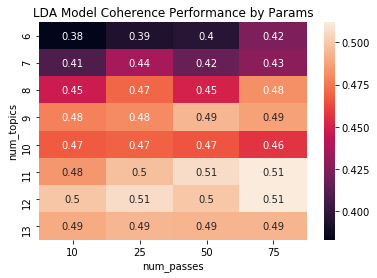

In [56]:
res = pd.pivot_table(pd.DataFrame(multi_model_df),
    values='coherence_score', index='num_topics', columns='num_passes')
ax = plt.axes()
ax.set_title("LDA Model Coherence Performance by Params")
sns.heatmap(res, annot=True)
plt.show()

In [59]:
multi_model_df[(multi_model_df["num_topics"]==11) & (multi_model_df["num_passes"]==75)]

,num_topics,num_passes,model,coherence_score
23,11,75,"LdaModel(num_terms=22697, num_topics=11, decay...",0.511452


In [77]:
pprint(multi_model_df['model'].iloc[23].print_topics())

[(0,
  '0.018*"hurricane" + 0.013*"island" + 0.012*"water" + 0.012*"storm" + '
  '0.011*"rico" + 0.011*"year" + 0.010*"people" + 0.009*"puerto" + '
  '0.008*"area" + 0.008*"space"'),
 (1,
  '0.013*"group" + 0.012*"state" + 0.012*"people" + 0.010*"immigration" + '
  '0.007*"program" + 0.007*"law" + 0.006*"student" + 0.006*"school" + '
  '0.006*"organization" + 0.006*"country"'),
 (2,
  '0.025*"woman" + 0.011*"time" + 0.010*"weinstein" + 0.010*"harassment" + '
  '0.008*"year" + 0.007*"hollywood" + 0.007*"harvey" + 0.007*"men" + '
  '0.006*"company" + 0.006*"car"'),
 (3,
  '0.024*"drug" + 0.021*"people" + 0.016*"study" + 0.013*"health" + '
  '0.012*"treatment" + 0.010*"pain" + 0.009*"patient" + 0.008*"police" + '
  '0.008*"use" + 0.007*"addiction"'),
 (4,
  '0.036*"health" + 0.021*"care" + 0.018*"trump" + 0.017*"insurance" + '
  '0.016*"plan" + 0.015*"state" + 0.013*"law" + 0.012*"president" + '
  '0.012*"bill" + 0.012*"people"'),
 (5,
  '0.024*"climate" + 0.020*"change" + 0.015*"energy" 

## Bigrams with Title

In [119]:
#clean data
def clean_data(text):
    #remove punctuation, digits, extra stuff. make lowercase
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    #lemma it - include POS tag in order to lemma it better
    tag_map = defaultdict(lambda : wordnet.NOUN)
    tag_map['J'] = wordnet.ADJ
    tag_map['V'] = wordnet.VERB
    tag_map['R'] = wordnet.ADV
    lemmatizer = WordNetLemmatizer()
    textTokens = word_tokenize(text)
    text = [lemmatizer.lemmatize(tok, tag_map[tag[0]]) for tok, tag in pos_tag(textTokens)]
    return " ".join(text)

In [120]:
cdata = data_raw
cdata["content_body_clean"] = cdata["content_body_clean"].apply(clean_data)
cdata["content_title_clean"] = cdata["content_title_clean"].apply(clean_data)

In [122]:
concat_data = pd.DataFrame(columns=['content_id','content_full_clean'])
for i in range(0,len(cdata)):
    full_content = cdata['content_title_clean'].iloc[i] + " " + cdata['content_body_clean'].iloc[i]
    concat_data = concat_data.append({'content_id':cdata['content_id'].iloc[i],
                                     'content_full_clean':full_content}, ignore_index=True)

In [123]:
concat_data.head()

,content_id,content_full_clean
0,60,tax reform now failure to act could mean minor...
1,61,tax reform america need a tax code thats good ...
2,66,longmothballed la vega strip casinohotel sell ...
3,80,trump tax plan may free up corporate dollar bu...
4,82,hurricane harvey be a humanitarian disaster it...


In [124]:
cdata_nouns = pd.DataFrame(concat_data["content_full_clean"].apply(nouns))

In [125]:
cdata_words = list(sent_to_words(cdata_nouns['content_full_clean']))

In [126]:
cbigram = models.Phrases(cdata_words, min_count=5, threshold=100) # higher threshold fewer phrases.

In [127]:
cbigram_mod = models.phrases.Phraser(cbigram)

In [128]:
def make_bigrams(texts):
    return [cbigram_mod[doc] for doc in texts]

cdata_words_bigrams = make_bigrams(cdata_words)

In [129]:
# Create Dictionary
id2word_bg = corpora.Dictionary(cdata_words_bigrams)
# Create Corpus
texts_bg = cdata_words_bigrams
# Term Document Frequency
tdm_bg = [id2word_bg.doc2bow(text) for text in texts_bg]

In [144]:
bg_model = models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=12, random_state=100,
                               chunksize=140, passes=75, per_word_topics=True)
ce_model_lda = CoherenceModel(model=this_model, texts=data_words, dictionary=id2word, coherence='c_v')
bg_coherence_lda = ce_model_lda.get_coherence()

In [145]:
print(bg_coherence_lda)
pprint(bg_model.print_topics())

0.49356350592449194
[(0,
  '0.017*"rico" + 0.015*"island" + 0.014*"puerto" + 0.012*"space" + '
  '0.010*"people" + 0.009*"hurricane" + 0.009*"death" + 0.008*"power" + '
  '0.008*"water" + 0.007*"time"'),
 (1,
  '0.013*"group" + 0.011*"state" + 0.010*"immigration" + 0.007*"year" + '
  '0.007*"program" + 0.006*"student" + 0.006*"school" + 0.006*"university" + '
  '0.006*"country" + 0.005*"work"'),
 (2,
  '0.036*"woman" + 0.013*"time" + 0.011*"harassment" + 0.009*"weinstein" + '
  '0.009*"year" + 0.008*"men" + 0.007*"allegation" + 0.007*"hollywood" + '
  '0.007*"story" + 0.006*"people"'),
 (3,
  '0.035*"drug" + 0.021*"study" + 0.017*"health" + 0.016*"treatment" + '
  '0.015*"people" + 0.014*"pain" + 0.014*"patient" + 0.011*"doctor" + '
  '0.010*"researcher" + 0.010*"addiction"'),
 (4,
  '0.035*"health" + 0.021*"care" + 0.017*"trump" + 0.017*"state" + '
  '0.015*"insurance" + 0.014*"plan" + 0.012*"administration" + 0.012*"people" '
  '+ 0.012*"bill" + 0.011*"president"'),
 (5,
  '0.028*"cl

In [141]:
this_doc = id2word_bg.doc2bow(texts_bg[0])
len(sorted(bg_model.get_document_topics(this_doc), key=lambda x: x[1], reverse=True))

3

In [147]:
topics = pd.DataFrame(columns=['content_id','content_body_clean','content_title_clean','topic_id1',
                               'topic_p1','topic_id2','topic_p2','topic_dist'])

for r in range(0,len(data_raw)):
    this_doc = id2word.doc2bow(texts_bg[r])
    topicID = sorted(bg_model.get_document_topics(this_doc), key=lambda x: x[1], reverse=True)
    if len(topicID) > 1:
        topicID2 = topicID[1]
    else:
        topicID2 = ["",""]
    
    topics = topics.append({'content_id': data_raw['content_id'].iloc[r], 
                            'content_body_clean':data_raw['content_body_clean'].iloc[r],
                            'content_title_clean':data_raw['content_title_clean'].iloc[r], 
                            'topic_id1':topicID[0][0],
                            'topic_p1':topicID[0][1], 
                            'topic_id2':topicID2[0],
                            'topic_p2':topicID2[1],
                            'topic_dist':bg_model.get_document_topics(this_doc) }, ignore_index=True)

In [148]:
topics

,content_id,content_body_clean,content_title_clean,topic_id1,topic_p1,topic_id2,topic_p2,topic_dist
0,60,republican in congress be at a make or break m...,tax reform now failure to act could mean minor...,9,0.808295,8,0.18727,"[(8, 0.18726669), (9, 0.8082982)]"
1,61,the constitution authorize congress to tax ame...,tax reform america need a tax code thats good ...,9,0.825752,2,0.101947,"[(2, 0.1019494), (8, 0.028617544), (9, 0.82575..."
2,66,a longmothballed unfinished casinohotel on the...,longmothballed la vega strip casinohotel sell for,5,0.340630,9,0.283061,"[(2, 0.14067338), (5, 0.3406284), (7, 0.098336..."
3,80,if taxing foreign earnings that have already a...,trump tax plan may free up corporate dollar bu...,9,0.930557,6,0.0627146,"[(6, 0.06271082), (9, 0.9305609)]"
4,82,hurricane harvey have already take an enormous...,hurricane harvey be a humanitarian disaster it...,7,0.435350,11,0.289463,"[(5, 0.2714762), (7, 0.4353441), (11, 0.289462..."
...,...,...,...,...,...,...,...,...
1909,3380,in this oct file photo venezuela president nic...,investor leave venezuela meeting with no clear...,8,0.231179,1,0.221951,"[(1, 0.22195064), (2, 0.031456262), (6, 0.1937..."
1910,3381,a man watch stock price board at a brokerage h...,global stock turn low after recent record high,7,0.819152,9,0.138986,"[(7, 0.8191529), (9, 0.13898557), (11, 0.02844..."
1911,3382,the draining of a massive aquifer that underli...,rural area at risk a water level drop in massi...,11,0.696730,2,0.179475,"[(2, 0.1794671), (5, 0.068339504), (10, 0.0504..."
1912,3383,orbital atks antares rocket lift off from wall...,frozen treat other supply rocket toward space ...,0,0.531346,6,0.226094,"[(0, 0.5313386), (1, 0.05577289), (2, 0.055255..."


In [149]:
topics.to_csv("Data/article_topics.csv")

### Original

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_raw_list = data_raw['content_body_clean'])tolist()
data_words = list(sent_to_words(data))

data_words = list(sent_to_words(data_nouns['content_body_clean']))